In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import json
from PIL import Image
import numpy as np
import os
from sklearn.model_selection import train_test_split
import cv2
from torchvision.transforms import functional as TF
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import random

In [2]:
class Transform:
    def __init__(self):
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(30),
        ])

    def __call__(self, image, mask):
        seed = torch.randint(0, 100000, (1,)).item()  
        random.seed(seed)  
        torch.manual_seed(seed)
        image = self.transform(image)

        random.seed(seed) 
        torch.manual_seed(seed)
        mask = self.transform(mask)

        return image, mask

def json_to_mask(mask_json, image_size):
    """ Convert JSON object to a mask numpy array """
    mask = np.zeros((image_size[1], image_size[0]), dtype=np.uint8)  
    for shape in mask_json['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)  
    return mask

class BuildingCrackDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_file = os.path.join(self.root_dir, self.files[idx])
        json_file = img_file.replace('.jpg', '.json')
        
        image = Image.open(img_file).convert("RGB")
        
        with open(json_file, 'r') as file:
            mask_json = json.load(file)
        mask = json_to_mask(mask_json, image.size)
        mask = Image.fromarray(mask)  
        
        if self.transform:
            image, mask = self.transform(image, mask)
        
        return transforms.ToTensor()(image), transforms.ToTensor()(mask)


transform = Transform()
dataset = BuildingCrackDataset('/home/adityab/ADRL/A1/Segmented major_crack', transform=transform)



In [3]:

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


In [4]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1,1), stride=(1,1))  # Adjust the output channel to match the number of classes (e.g., binary mask)
model.to(device)


criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
                dataloader = train_loader
            else:
                model.eval()   
                dataloader = val_loader

            running_loss = 0.0

            
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                
                optimizer.zero_grad()

                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)['out']
                    loss = criterion(outputs, labels)

                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f}')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model

trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25)


/home/adityab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adityab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/25
----------
train Loss: 0.1603
val Loss: 0.4076

Epoch 2/25
----------
train Loss: 0.0703
val Loss: 0.4099

Epoch 3/25
----------
train Loss: 0.0656
val Loss: 2.0651

Epoch 4/25
----------
train Loss: 0.0586
val Loss: 0.0519

Epoch 5/25
----------
train Loss: 0.0552
val Loss: 0.0799

Epoch 6/25
----------
train Loss: 0.0549
val Loss: 0.0459

Epoch 7/25
----------
train Loss: 0.0502
val Loss: 0.0478

Epoch 8/25
----------
train Loss: 0.0480
val Loss: 0.0481

Epoch 9/25
----------
train Loss: 0.0458
val Loss: 0.0393

Epoch 10/25
----------
train Loss: 0.0451
val Loss: 0.2574

Epoch 11/25
----------
train Loss: 0.0451
val Loss: 0.8692

Epoch 12/25
----------
train Loss: 0.0467
val Loss: 0.9090

Epoch 13/25
----------
train Loss: 0.0472
val Loss: 0.0597

Epoch 14/25
----------
train Loss: 0.0430
val Loss: 0.0384

Epoch 15/25
----------
train Loss: 0.0471
val Loss: 0.0374

Epoch 16/25
----------
train Loss: 0.0426
val Loss: 0.0386

Epoch 17/25
----------
train Loss: 0.0410
val Los

In [8]:
def test_model_and_visualize(model, test_loader, criterion, device, threshold=0.7, num_images=5):
    model.eval()
    running_loss = 0.0
    total_pixels = 0
    correct_pixels = 0

    images = []
    predictions = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)['out']
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            total_pixels += labels.numel()
            correct_pixels += ((outputs > threshold) == labels).sum().item()

            preds = outputs > threshold

            if len(images) < num_images:
                images.extend(inputs.cpu().numpy())
                predictions.extend(preds.cpu().numpy())
                labels_list.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    accuracy = correct_pixels / total_pixels

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')

    return images, predictions, labels_list


In [9]:
def visualize_predictions(images, predictions, labels_list, num_images=5):
    fig, axs = plt.subplots(num_images, 3, figsize=(15, 10))
    for i in range(num_images):
        img = np.transpose(images[i], (1, 2, 0))  
        img = (img - img.min()) / (img.max() - img.min())  
        
        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(predictions[i][0], cmap='gray')
        axs[i, 1].set_title('Predicted Mask')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(labels_list[i][0], cmap='gray')
        axs[i, 2].set_title('True Mask')
        axs[i, 2].axis('off')

    plt.show()

    
    predictions_flat = np.array(predictions).flatten()
    labels_flat = np.array(labels_list).flatten()
    print('Precision:', precision_score(labels_flat, predictions_flat))
    print('Recall:', recall_score(labels_flat, predictions_flat))
    print('F1 Score:', f1_score(labels_flat, predictions_flat))


Test Loss: 0.0406
Test Accuracy: 0.9842


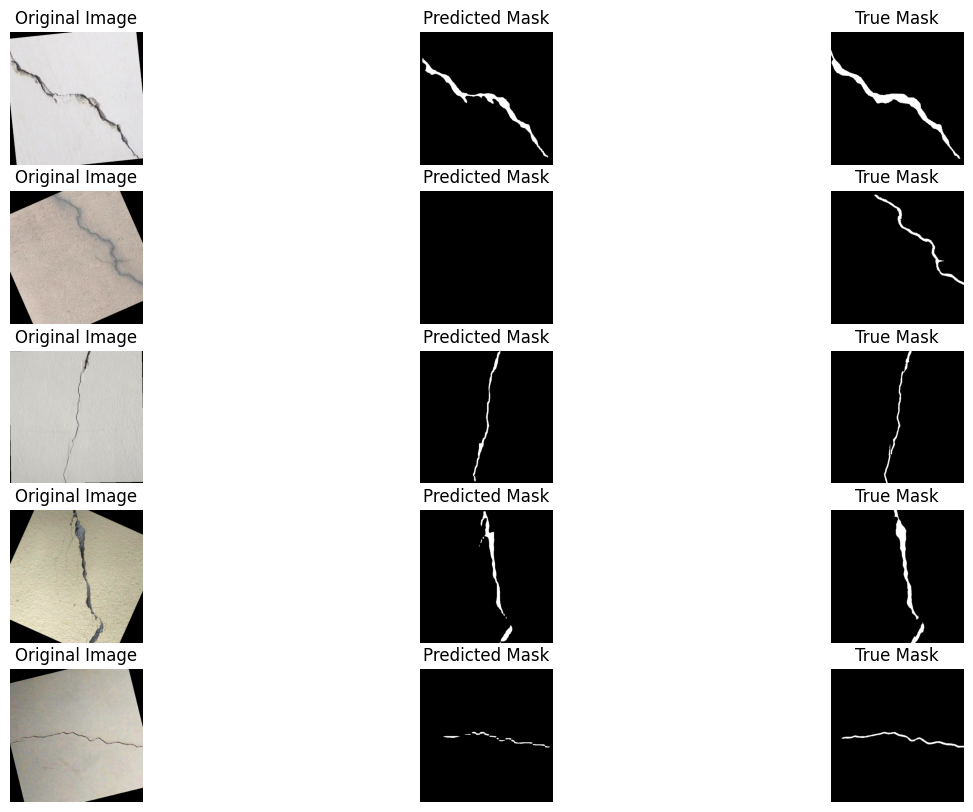

Precision: 0.9110993049099039
Recall: 0.6089722723640991
F1 Score: 0.7300106420716567


In [10]:
images, predictions, labels_list = test_model_and_visualize(model, test_loader, criterion, device)
visualize_predictions(images, predictions, labels_list)

# This one

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import json
from PIL import Image
import numpy as np
import os
from sklearn.model_selection import train_test_split
import cv2
from torchvision.transforms import functional as TF
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import random

In [5]:
class Transform:
    def __init__(self):
        self.transform = transforms.Compose([
            #transforms.Resize((256, 256)),  # Ensures large enough spatial dimensions
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(30),
        ])

    def __call__(self, image, mask):
        seed = torch.randint(0, 100000, (1,)).item()
        random.seed(seed)
        torch.manual_seed(seed)
        image = self.transform(image)

        random.seed(seed)
        torch.manual_seed(seed)
        mask = self.transform(mask)

        return image, mask



def json_to_mask(mask_json, image_size):
    """ Convert JSON object to a mask numpy array """
    mask = np.zeros((image_size[1], image_size[0]), dtype=np.uint8)  
    for shape in mask_json['shapes']:
        points = np.array(shape['points'], dtype=np.int32)
        cv2.fillPoly(mask, [points], 255)  
    return mask

class BuildingCrackDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Only keep .jpg files that have corresponding .json
        self.files = []
        for f in os.listdir(root_dir):
            if f.endswith('.jpg'):
                json_file = f.replace('.jpg', '.json')
                if os.path.exists(os.path.join(root_dir, json_file)):
                    self.files.append(f)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            img_file = os.path.join(self.root_dir, self.files[idx])
            json_file = img_file.replace('.jpg', '.json')

            image = Image.open(img_file).convert("RGB")

            with open(json_file, 'r') as file:
                mask_json = json.load(file)
            mask = json_to_mask(mask_json, image.size)
            mask = Image.fromarray(mask)

            if self.transform:
                image, mask = self.transform(image, mask)

            return transforms.ToTensor()(image), transforms.ToTensor()(mask)

        except Exception as e:
            print(f"Skipping {self.files[idx]} due to error: {e}")
            return self.__getitem__((idx + 1) % len(self))



transform = Transform()
dataset = BuildingCrackDataset('/home/adityab/ADRL/final/Data', transform=transform)



In [6]:

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


In [7]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
#train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=1, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/adityab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adityab/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
----------
train Loss: 0.0875
val Loss: 0.1724

Epoch 2/50
----------
train Loss: 0.0582
val Loss: 0.4284

Epoch 3/50
----------
train Loss: 0.0524
val Loss: 0.0483

Epoch 4/50
----------
train Loss: 0.0502
val Loss: 0.0499

Epoch 5/50
----------
train Loss: 0.0477
val Loss: 0.0447

Epoch 6/50
----------
train Loss: 0.0467
val Loss: 0.0446

Epoch 7/50
----------
train Loss: 0.0454
val Loss: 0.0468

Epoch 8/50
----------
train Loss: 0.0447
val Loss: 0.0418

Epoch 9/50
----------
train Loss: 0.0438
val Loss: 0.0432

Epoch 10/50
----------
train Loss: 0.0421
val Loss: 0.0423

Epoch 11/50
----------
train Loss: 0.0422
val Loss: 0.0409

Epoch 12/50
----------
train Loss: 0.0411
val Loss: 0.0413

Epoch 13/50
----------
train Loss: 0.0401
val Loss: 0.0416

Epoch 14/50
----------
train Loss: 0.0396
val Loss: 0.0391

Epoch 15/50
----------
train Loss: 0.0394
val Loss: 0.0385

Epoch 16/50
----------
train Loss: 0.0395
val Loss: 0.0399

Epoch 17/50
----------
train Loss: 0.0388
val Los

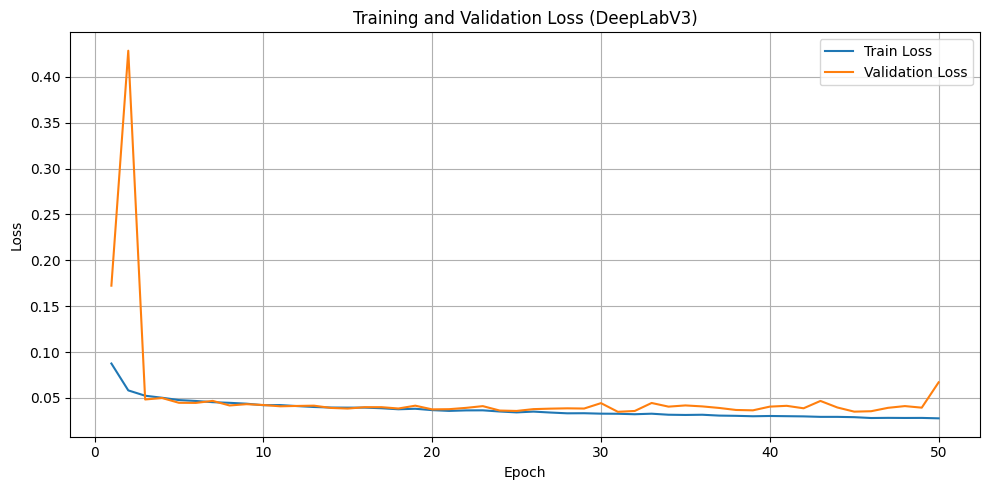

In [9]:
import time
import matplotlib.pyplot as plt
from torchvision import models

model = models.segmentation.deeplabv3_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256, 1, kernel_size=(1,1), stride=(1,1))  # Binary output
model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    since = time.time()

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0

            for inputs, labels in dataloader:
                if inputs.shape[-1] < 32 or inputs.shape[-2] < 32:
                    print(f"Skipping tiny input: {inputs.shape}")
                    continue
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)['out']
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)

            if phase == 'train':
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f}')
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss (DeepLabV3)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return model

trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)


In [11]:
def test_model_and_visualize(model, test_loader, criterion, device, threshold=0.5, num_images=5):
    model.eval()
    running_loss = 0.0
    total_pixels = 0
    correct_pixels = 0

    images = []
    predictions = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)['out']
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            total_pixels += labels.numel()
            correct_pixels += ((outputs > threshold) == labels).sum().item()

            preds = outputs > threshold

            if len(images) < num_images:
                images.extend(inputs.cpu().numpy())
                predictions.extend(preds.cpu().numpy())
                labels_list.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    accuracy = correct_pixels / total_pixels

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')

    return images, predictions, labels_list


In [12]:
def compute_mean_dice_iou(preds, labels, eps=1e-7):
    dices = []
    ious = []
    for p, l in zip(preds, labels):
        p = p.flatten().astype(np.uint8)
        l = (l.flatten() > 0.5).astype(np.uint8)

        intersection = (p * l).sum()
        union = p.sum() + l.sum()
        dice = (2 * intersection + eps) / (union + eps)
        iou = (intersection + eps) / (p.sum() + l.sum() - intersection + eps)

        dices.append(dice)
        ious.append(iou)
    return np.mean(dices), np.mean(ious)

def visualize_predictions(images, predictions, labels_list, num_images=5):
    fig, axs = plt.subplots(num_images, 3, figsize=(15, 10))
    for i in range(num_images):
        img = np.transpose(images[i], (1, 2, 0))  
        img = (img - img.min()) / (img.max() - img.min())  
        
        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')

        axs[i, 1].imshow(predictions[i][0], cmap='gray')
        axs[i, 1].set_title('Predicted Mask')
        axs[i, 1].axis('off')

        axs[i, 2].imshow(labels_list[i][0], cmap='gray')
        axs[i, 2].set_title('True Mask')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Flatten for standard metrics
    predictions_flat = np.array(predictions).astype(np.uint8).flatten()
    labels_flat = (np.array(labels_list) > 0.5).astype(np.uint8).flatten()

    print('Precision:', precision_score(labels_flat, predictions_flat))
    print('Recall:', recall_score(labels_flat, predictions_flat))
    print('F1 Score:', f1_score(labels_flat, predictions_flat))

    # mIoU and Dice Score
    dice, miou = compute_mean_dice_iou(predictions, labels_list)
    print(f'Mean Dice Score: {dice:.4f}')
    print(f'Mean IoU (mIoU): {miou:.4f}')


Test Loss: 0.0715
Test Accuracy: 0.9787


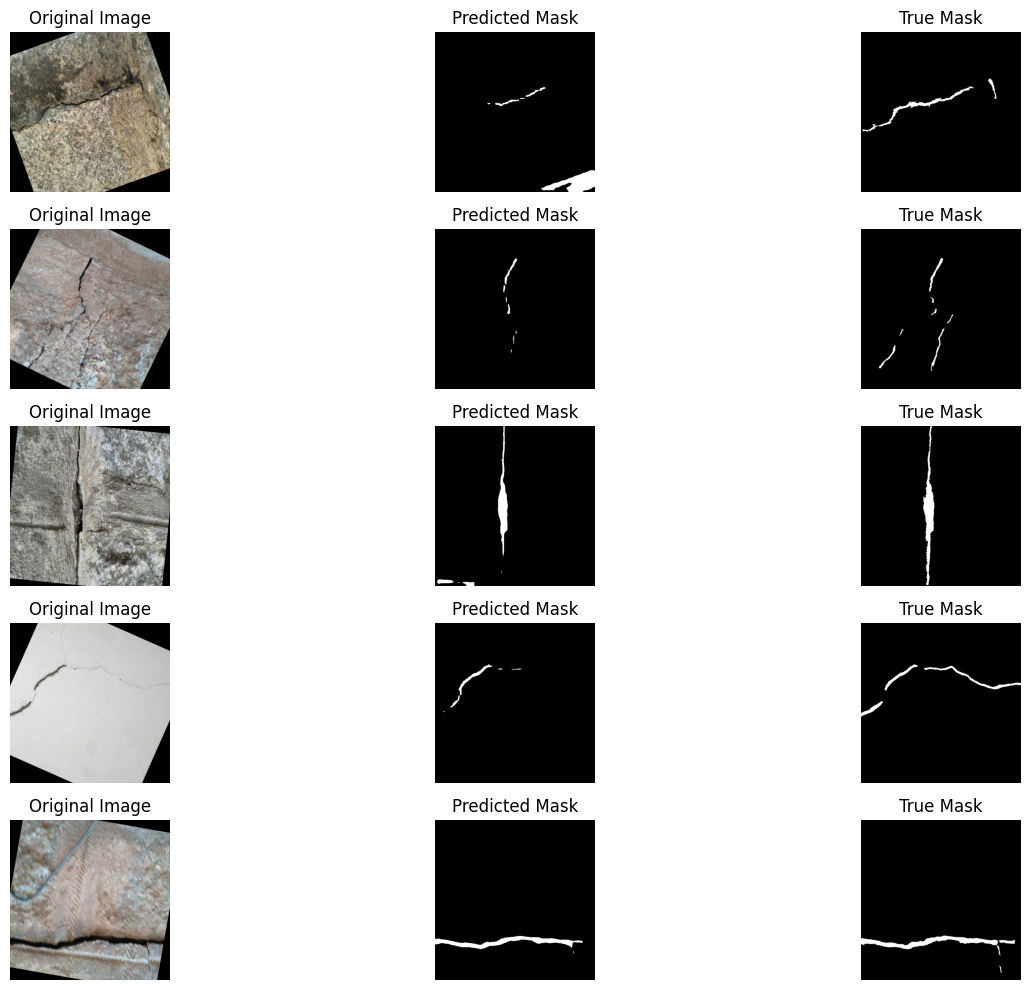

Precision: 0.6566444518726656
Recall: 0.44126356451796644
F1 Score: 0.5278279548533426
Mean Dice Score: 0.4857
Mean IoU (mIoU): 0.3667


In [13]:
images, predictions, labels_list = test_model_and_visualize(model, test_loader, criterion, device, num_images=len(test_dataset))
visualize_predictions(images, predictions, labels_list)
